# This notebook reads text data from data extract created from FSHA Forms and runs predictive Models to predict the value 'Are there any inherent or cross contact allergens or intolerants?' , based on the Input Data

In [27]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import warnings
warnings.simplefilter('ignore')

## File name and other important parameters like ngram_range set

In [28]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "C:/Pepsico/FSHA RPA - 25 July 2019 - 209Files.xlsm"
#n_components = 0

In [4]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\09263248\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) - Q1

In [29]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from','dtype','object']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

#normalize_corpus = np.vectorize(normalize_document)

In [30]:
#import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

#nlp = spacy.load('en', parse = False, tag=False, entity=False)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)

        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [31]:
fsha_data = pd.read_excel(filename)

In [32]:
fsha_data.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,Table1_Row6_Molluscs,Table1_Row6_Mustard,Table1_Row6_Sesame Seeds,Table1_Row6_Sulphites,Table1_Row1_Moulluscs,Table1_Row2_Moulluscs,Table1_Row3_Moulluscs,Table1_Row4_Moulluscs,Table1_Row5_Moulluscs,Table1_Row6_Moulluscs
0,#46565 FSHA 5.4.1Star Project G3 v2 + FS input...,S-T3-Star-• POL Star Puff (Chrupki) quality –POL,46565,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,Brand Refresh,Star Puffs Cheese & STar Hyper Cheese\nSeasoni...,NaN,Weronika Baranowska,ESSA,Warsaw,...,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,#53697 FSHA HT Baguette 4 Cheese UA 2.07.19.xlsm,HT Baguette Four Cheese Flavor,53697,Hrusteam Baguette,Refresh,Launch new seasoning 4 Cheese NL-502-352-9 on ...,NaN,Anna Nikonova,ESSA,Moscow,...,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,#57686 FSHA 5.4.1 Red Caviar Azov.xlsm,Lay's Caviar IO 2019 RUS Asov,57686,Lay's Red Caviar,Refresh,Idea is to launch I&O flavour under New Year p...,Not provided,Evgeniy Shklovskiy +79163257848,ESSA,Moscow,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,#57686 FSHA 5.4.1 Red Caviar Kashira.xlsm,Lay's Caviar IO 2019 RUS Kashira,57686,Lay's Red Caviar,Refresh,Idea is to launch I&O flavour under New Year p...,Not provided,Evgeniy Shklovskiy +79163257848,ESSA,Moscow,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,53354-FSHA-In Process 13.12.18.xlsm,Soft and Mild Iberia 2019,53354,Cheetos Palomito,Re Launch,"Re Launch of Cheetos Palomitos, Soft Extruded ...",CP2019,David Labrado 07770646572,ESSA,Beaumont Park,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Based on Analysis select the Features (X)

In [33]:
#selecting set of columns as Features
data2=fsha_data[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient']]

In [34]:
data2

,preservatives,pH,waterActivity,packaging,otherFSA,prodStorageDist,foodSafetyProdClaims,targetMarket,allergens,newIngredient
0,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.","claim 1 ""from corn""\nclaim 2 ""not fried""\nclai...","People with allergies to milk, lactose, peanuts.",Allergens in seasonings:\nCQ69 Vegetable Blend...,Yes
1,no,no,low water activity,n/a,no,"Keep at temperature 25 °C, <75% humidity",n/a,No,No new allergen to the line from seasonings. 4...,Yes
2,Not,NaN,Low water activity,standard,None,air temperature is not higher than 25 ˚С and r...,n/a,people with allergy to ingredients in the prod...,"Inherent: Milk, Lactose, Wheat, Gluten, Fish c...",No
3,Not,NaN,Low water activity,standard,None,air temperature is not higher than 25 ˚С and r...,n/a,people with allergy to ingredients in the prod...,"Inherent : Inherent: Milk, Lactose, Wheat, Gl...",No
4,NaN,NaN,Low water activity,window with clear film.,NaN,"Product to be sold in Iberia, storage in ambie...",Gluten free?,Kids from 4-10,Milk from Seasoning.,No
5,\n\nCitric acid E-330\nSilicon dioxide E-551\...,NaN,Low water activity,Ambiant packaging/modified atmosphere without ...,NaN,NaN,NaN,NO,"wheat starch, rusk from wheat from paprika sea...",Yes
6,\n\nCitric acid E-330\nSilicon dioxide E-551\...,NaN,Low water activity finished product,Ambiant packaging/modified atmosphere without ...,NaN,NaN,NaN,NO,"wheat starch, rusk from wheat from paprika sea...",Yes
7,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.",no claims,People with allergies to allergens present in ...,"One of below seasonings will be chosen, allerg...",No
8,not present in seasoning,not known yet for reformulated seasoning - exi...,"Max 5% in seasoning, FP aim 1,8% and max 2,2%",Packed in a protective atmosphere,None,none,none,no,"milk, Soya, Barley",No
9,not present in seasoning,not known yet for reformulated seasoning - exi...,"Max 5% in seasoning, FP aim 1,8% and max 2,2%",Packed in a protective atmosphere,None,none,none,no,"milk, Soya, Barley",No


# Replace missing values with NA

In [35]:
data2.fillna('NA', inplace=True)

In [36]:
data2

,preservatives,pH,waterActivity,packaging,otherFSA,prodStorageDist,foodSafetyProdClaims,targetMarket,allergens,newIngredient
0,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.","claim 1 ""from corn""\nclaim 2 ""not fried""\nclai...","People with allergies to milk, lactose, peanuts.",Allergens in seasonings:\nCQ69 Vegetable Blend...,Yes
1,no,no,low water activity,n/a,no,"Keep at temperature 25 °C, <75% humidity",n/a,No,No new allergen to the line from seasonings. 4...,Yes
2,Not,NA,Low water activity,standard,None,air temperature is not higher than 25 ˚С and r...,n/a,people with allergy to ingredients in the prod...,"Inherent: Milk, Lactose, Wheat, Gluten, Fish c...",No
3,Not,NA,Low water activity,standard,None,air temperature is not higher than 25 ˚С and r...,n/a,people with allergy to ingredients in the prod...,"Inherent : Inherent: Milk, Lactose, Wheat, Gl...",No
4,NA,NA,Low water activity,window with clear film.,NA,"Product to be sold in Iberia, storage in ambie...",Gluten free?,Kids from 4-10,Milk from Seasoning.,No
5,\n\nCitric acid E-330\nSilicon dioxide E-551\...,NA,Low water activity,Ambiant packaging/modified atmosphere without ...,NA,NA,NA,NO,"wheat starch, rusk from wheat from paprika sea...",Yes
6,\n\nCitric acid E-330\nSilicon dioxide E-551\...,NA,Low water activity finished product,Ambiant packaging/modified atmosphere without ...,NA,NA,NA,NO,"wheat starch, rusk from wheat from paprika sea...",Yes
7,None,Not applicable,low moisture food,no modified atmosphere,Not applicable,"Store in a dry, cool and away from sun place.",no claims,People with allergies to allergens present in ...,"One of below seasonings will be chosen, allerg...",No
8,not present in seasoning,not known yet for reformulated seasoning - exi...,"Max 5% in seasoning, FP aim 1,8% and max 2,2%",Packed in a protective atmosphere,None,none,none,no,"milk, Soya, Barley",No
9,not present in seasoning,not known yet for reformulated seasoning - exi...,"Max 5% in seasoning, FP aim 1,8% and max 2,2%",Packed in a protective atmosphere,None,none,none,no,"milk, Soya, Barley",No


In [37]:
train_df = data2

# Define reusable code to Vectorize Text column (ex: Allergens) using TF-IDF Vectorizer, after doing Text data normalization

In [38]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE 

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Select top 'k' of the vectorized features.
    #selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    #selector.fit(x_train, train_labels)
    #x_train = selector.transform(x_train)

    x_train = x_train.astype('float32')
    return x_train

# Define method to concatenate normalized Text data

In [39]:
train_df.columns

Index(['preservatives', 'pH', 'waterActivity', 'packaging', 'otherFSA',
       'prodStorageDist', 'foodSafetyProdClaims', 'targetMarket', 'allergens',
       'newIngredient'],
      dtype='object')

In [40]:
train_df['norm_preservatives']=normalize_corpus(train_df['preservatives'])
train_df['norm_prodStorage'] = normalize_corpus(train_df['prodStorageDist'])

In [44]:
train_df['norm_prodStorage'][:5].values

array(['store dry cool away sun place',
       'keep temperature 25 c 75 humidity',
       'air temperature not higher 25 relative humidity air not 75',
       'air temperature not higher 25 relative humidity air not 75',
       'product sold iberia storage ambient prevent direct sun light'],
      dtype=object)

In [45]:
train_df['norm_preservatives'][:5].values

array(['none', 'no', 'not', 'not', 'na'], dtype=object)

In [47]:
train_df['comb']=train_df['norm_preservatives']+" "+train_df['norm_prodStorage']

In [48]:
train_df['comb'][:5].values

array(['none store dry cool away sun place',
       'no keep temperature 25 c 75 humidity',
       'not air temperature not higher 25 relative humidity air not 75',
       'not air temperature not higher 25 relative humidity air not 75',
       'na product sold iberia storage ambient prevent direct sun light'],
      dtype=object)

In [49]:
train_df['norm_preservatives'] = normalize_corpus(train_df['preservatives'])
train_df['norm_prodStorage'] = normalize_corpus(train_df['prodStorageDist'])
train_df['norm_packaging'] = normalize_corpus(train_df['packaging'])
train_df['norm_otherFSA'] = normalize_corpus(train_df['otherFSA'])
train_df['norm_prodStorageDist'] = normalize_corpus(train_df['prodStorageDist'])
train_df['norm_foodSafety_prodClaims'] = normalize_corpus(train_df['foodSafetyProdClaims'])
train_df['norm_targetMarket'] = normalize_corpus(train_df['targetMarket'])
train_df['norm_newIngredient'] = normalize_corpus(train_df['newIngredient'])
train_df['norm_allergens'] = normalize_corpus(train_df['allergens'])
train_df['all_cols'] = train_df['norm_preservatives']+" "+train_df['norm_prodStorage']+" "+train_df['norm_packaging']+" "+train_df['norm_otherFSA']+" "+train_df['norm_prodStorageDist']+" "+train_df['norm_foodSafety_prodClaims']+" "+train_df['norm_targetMarket']+" "+train_df['norm_newIngredient']+" "+train_df['norm_allergens']
   


In [50]:
train_df['all_cols'][2]

'not air temperature not higher 25 relative humidity air not 75 standard none air temperature not higher 25 relative humidity air not 75 na people allergy ingredients product no inherent milk lactose wheat gluten fish components present seasoning allergenic protein content confirmed givaudan 0 ppm crosscontact line soya crustacean fish crosscontact within plant soya crustacean mustard fish'

# Imput target with mode value

In [51]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if str(fsha_data[targetName][i]).strip().lower() =='yes':
            train_y.append(1)
        elif str(fsha_data[targetName][i]).strip().lower() =='no':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

# Three sets of targets 

In [53]:
train_y_microbial = impute_target(fsha_data,"potentialMicrobial")
train_y_chokeHazard = impute_target(fsha_data,"chokeHazard")
train_y_opAllergens = impute_target(fsha_data,"operationalAllergen")

In [54]:
train_df['target']=train_y_microbial

In [55]:
#Cannot be used since its all 1
#df['target']=train_y_allergens

In [467]:
#train_df['target']=train_y_chokeHazard

In [485]:
#train_df['target']=train_y_opAllergens

In [57]:
#train_df['target']

# Perform upsampling on text data and target

In [72]:
#sampled_df = train_df[['all_cols','target']].sample(n=1000,replace=True).reset_index()
sampled_df = train_df

In [73]:
#sampled_df['all_cols'].values[0]

In [74]:
sampled_df['target'].value_counts()

0    205
1      4
Name: target, dtype: int64

In [75]:
#sampled_df.to_csv('D:/Pepsico/AllCols_500.csv')

# Perform n-gram vectorization on concatenated text data

In [76]:
train_labels = train_y_microbial 
    
#Vectorize the text data, n_gram range = (1,1)
x_ngram = ngram_vectorize(sampled_df['all_cols'], train_labels,(1,1))
x_ngram=x_ngram.toarray()
print(x_ngram.shape)   

#Standard scaling on vectorized data
x_ngram_std = StandardScaler().fit_transform(x_ngram)   

(209, 284)


In [77]:
x_ngram_std[10,:]

array([-0.18346033, -0.17171186, -0.0982945 , -0.26794618, -0.09829452,
       -0.0982522 , -0.24369262, -0.09829461, -0.0982522 , -0.22285058,
       -0.12065652, -0.28776458, -0.26280773, -0.15652831, -0.26794618,
       -0.12054575, -0.12054575, -0.15341917, -0.09392384, -0.2546122 ,
       -0.18568937, -0.15042639, -0.09829275, -0.4903086 , -0.13378401,
       -0.21144006, -0.09114681, -0.13903347, -0.13950749, -1.2421268 ,
       -0.5304989 , -0.28776458, -0.55574995, -0.09829461,  1.5476768 ,
       -0.39914298, -0.09065374, -0.154814  ,  2.317377  , -0.4251941 ,
       -0.16722788, -0.3161204 , -0.09828392, -0.12067523, -0.12067523,
       -0.13968606, -0.0958496 , -0.09829462, -0.0940121 , -0.50092065,
       -0.41905275, -0.16917449, -0.20915754, -0.3462052 , -0.25375822,
       -0.14615795, -0.12065652, -0.09781845, -0.22285058, -0.11864518,
       -0.23971948, -0.13959882, -0.09493382, -0.6220603 , -0.09829462,
       -0.12065652, -0.09829275, -0.13916276, -0.10452354, -0.11

# Perform train test split

In [78]:
X,y = x_ngram_std,sampled_df['target']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [80]:
print(X_train.shape)
print(X_test.shape)

(167, 284)
(42, 284)


# Apply PCA 

In [81]:
#Apply PCA 
whiten = False
random_state = 42
svd_solver="full"
n_comp = 2

pca = PCA(n_components=n_comp,svd_solver=svd_solver,whiten=whiten, random_state=42)
pca.fit(X_train)
x_train_pca = pca.transform(X_train)

x_test_pca = pca.transform(X_test)
    
print(x_train_pca.shape)
print(x_test_pca.shape)

(167, 2)
(42, 2)


# Define method to evaluate Machine Learning models with the X and y vectors created above, and check the effectiveness of each. Also store the results in array to be plotted in graph for visualization

In [82]:
from datetime import datetime
import time
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(len(X_train))
    
    clf_descr = str(clf).split('(')[0]
    print("model name:"+clf_descr)
  
    a = datetime.now()
    
    if clf_descr.__contains__('tensorflow'):
        history = clf.fit(
            X_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_test, y_test),
            verbose=2, 
            batch_size=batch_size)
    else:
        clf.fit(X_train, y_train)
    
    b = datetime.now()
    c = a-b
    train_time = c.microseconds
    print("train time: %0.3fs" % train_time)

    pred = clf.predict(X_test)

    pred_train = clf.predict(X_train)
 
    if clf_descr.__contains__('tensorflow'):
        for i in range (len(pred)):
            if (pred[i]>=0.3):
                pred[i]=1
            else:
                pred[i]=0
        for i in range (len(pred_train)):        
            if (pred_train[i]>=0.3):
                pred_train[i]=1
            else:
                pred_train[i]=0
    
    f1_score = metrics.f1_score(y_test, pred, average="weighted")
    print("f1_score:   %0.3f" % f1_score )
    
    f1_score_train = metrics.f1_score(y_train, pred_train, average="weighted")
    print("f1_score_train:   %0.3f" % f1_score_train )
    
    print("classification report:")
    print(classification_report(y_test, pred))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    
    return clf_descr,f1_score_train,f1_score,train_time

# Evaluate Machine Learning Models from a List (using the reusable method defined above). Store the results (Accuracy score - train, accuracy score - test, and training time) in a List for data visualization

In [83]:
# Not using MultinomialNaiveBayes, because sampled data has negative components. NaiveBayes expects frequencies in the positive
selector = SelectKBest(f_classif, k='all')
results = []
model_name = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    selector_clf = benchmark(Pipeline([('selector', selector),('classifier', clf)]))
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    model_name.append(name)
    #model.append(clf)
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,dual=False, tol=1e-3)))
    model_name.append("LinearSVC"+" "+penalty)

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty=penalty)))
    model_name.append("SGDClassifier"+" "+penalty)


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")))
model_name.append("SGD with Elastic Net penalty")


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))
model_name.append("NearestCentroid (aka Rocchio classifier)")


________________________________________________________________________________
Training: 
167
model name:Pipeline
train time: 968763.000s
f1_score:   1.000
f1_score_train:   1.000
classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        42

avg / total       1.00      1.00      1.00        42

confusion matrix:
[[42]]
Ridge Classifier
________________________________________________________________________________
Training: 
167
model name:RidgeClassifier
train time: 968740.000s
f1_score:   1.000
f1_score_train:   1.000
classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        42

avg / total       1.00      1.00      1.00        42

confusion matrix:
[[42]]
dimensionality: 284
density: 1.000000
________________________________________________________________________________
Training: 
167
model name:Pipeline
train time: 984356.000s
f1_score:   0.

# Define Neural Network model

In [84]:
def mlp_model(layers, units, dropout_rate, input_shape):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.

    # Returns
        An MLP model instance.
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Compile Model

In [85]:
learning_rate=1e-3
epochs=100
batch_size=128
layers=2
units=64
dropout_rate=0.2
model = mlp_model(layers=layers,units=units,dropout_rate=dropout_rate,input_shape=X.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model.summary()

W0812 09:27:20.754323  3724 deprecation.py:506] From C:\Users\09263248\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0812 09:27:20.988677  3724 deprecation.py:323] From C:\Users\09263248\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 284)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                18240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 18,305
Trainable params: 18,305
Non-trainable params: 0
_________________________________________________________________


# Train model and store results in array

In [86]:
print('=' * 80)
print("Keras Dense Neural Network")
results.append(benchmark(model))
model_name.append("Keras Dense Neural Network")

Keras Dense Neural Network
________________________________________________________________________________
Training: 
167
model name:<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FFDECA0828>
Train on 167 samples, validate on 42 samples
Epoch 1/100
167/167 - 0s - loss: 0.6604 - acc: 0.5988 - val_loss: 0.4201 - val_acc: 0.7619
Epoch 2/100
167/167 - 0s - loss: 0.5422 - acc: 0.7246 - val_loss: 0.3406 - val_acc: 0.9524
Epoch 3/100
167/167 - 0s - loss: 0.5129 - acc: 0.7844 - val_loss: 0.2829 - val_acc: 0.9524
Epoch 4/100
167/167 - 0s - loss: 0.3774 - acc: 0.8862 - val_loss: 0.2397 - val_acc: 0.9762
Epoch 5/100
167/167 - 0s - loss: 0.3344 - acc: 0.9102 - val_loss: 0.2065 - val_acc: 0.9762
Epoch 6/100
167/167 - 0s - loss: 0.3268 - acc: 0.8802 - val_loss: 0.1770 - val_acc: 0.9762
Epoch 7/100
167/167 - 0s - loss: 0.2531 - acc: 0.9341 - val_loss: 0.1509 - val_acc: 1.0000
Epoch 8/100
167/167 - 0s - loss: 0.2044 - acc: 0.9581 - val_loss: 0.1300 - val_acc: 0.9762
Epoch 9/1

In [463]:
#import pickle
3results_fileName='D:/Pepsico/results_microbial_1000.pkl'
#with open(results_fileName, "wb") as f:
#    w = pickle.dump(results,f)

In [505]:
results = [[x[i] for x in results] for i in range(4)]
clf_names, f1_score_train1, f1_score_test1, training_time1 = results

In [ ]:
results = [[x[i] for x in results] for i in range(4)]
clf_names, f1_score_train2, f1_score_test2, training_time2 = results

In [ ]:
results = [[x[i] for x in results] for i in range(4)]
clf_names, f1_score_train3, f1_score_test3, training_time3 = results

In [ ]:
import scipy.stats

f1_score_train = scipy.stats.hmean(f1_score_train1,f1_score_train2,f1_score_train3)
f1_score_test = scipy.stats.hmean(f1_score_test1,f1_score_test2,f1_score_test3)
training_time=np.mean(training_time1,training_time2,training_time3)
print(f1_score_train)

In [507]:
np.max(f1_score_train1)

1.0

In [508]:
np.max(f1_score_test1)

1.0

In [510]:
np.mean(training_time1).round()

786654.0

In [354]:
#results_microbial=pd.read_pickle('D:/Pepsico/results_microbial_100.pkl')
#results_chokeHazard=pd.read_pickle('D:/Pepsico/results_chokeHazard_100.pkl')
#results_opAllergen=pd.read_pickle('D:/Pepsico/results_opAllergen_100.pkl')

In [ ]:
training_time = np.array(training_time) / np.max(training_time)

# Visualize the results from multiple Machine Learning Models (accuracy - train, accuracy - test, training time)

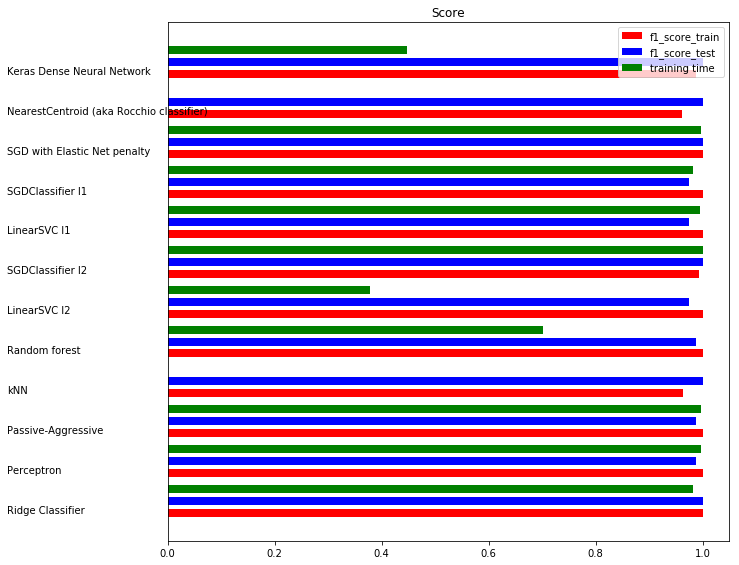

In [87]:
# make some plots
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, f1_score_train, f1_score_test, training_time = results

training_time = np.array(training_time) / np.max(training_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, f1_score_train, .2, label="f1_score_train", color='r')
plt.barh(indices+0.3, f1_score_test, .2, label="f1_score_test", color='b')
plt.barh(indices + .6, training_time, .2, label="training time", color='g')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, model_name):
    plt.text(-.3, i, c)

plt.show()

# Store the best model and accuracy for a sample Size in array

In [88]:
#Sample Size 100
index100=np.argmax(f1_score_test)
print(index100)
f1score100 = f1_score_test[index100]
print(f1score100)
print(model_name[index100])

0
1.0
Ridge Classifier


# Plot the accuracy scores (F1-scores) of the best model vs sample Size

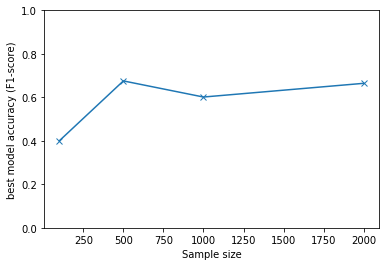

In [103]:
##Plotting the best model f1-scores

import matplotlib.pyplot as plt
plt.plot([100, 500, 1000, 2000],[f1score100,f1score500,f1score1000,f1score2000],marker="x")
plt.ylim(0,1)
plt.ylabel('best model accuracy (F1-score)')
plt.xlabel('Sample size')
plt.show()

# Print the best Model names at various sample Sizes

In [104]:
print("Best classifier is:"+model_name[index100],"||f1_score",f1score100)
print("Best classifier is:"+model_name[index500],"||f1_score",f1score500)
print("Best classifier is:"+model_name[index1000],"||f1_score",f1score1000)
print("Best classifier is:"+model_name[index2000],"||f1_score",f1score2000)

Best classifier is:Ridge Classifier ||f1_score 0.4
Best classifier is:Ridge Classifier ||f1_score 0.6754966887417219
Best classifier is:Ridge Classifier ||f1_score 0.6013986013986015
Best classifier is:kNN ||f1_score 0.664440734557596
